In [1]:
import numpy as np
import pandas as pd
from keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from keras.models import load_model
import tensorflow as tf
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

from scipy.stats import uniform, shapiro, wilcoxon
from sklearn.model_selection import RandomizedSearchCV
from sklearn.multioutput import MultiOutputClassifier
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from scipy.stats import ttest_rel
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, Dense, Bidirectional, GlobalMaxPool1D, LSTM

import prepare_data as prep
from prepare_data import DataPreprocessor
from importlib import reload
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

reload(prep)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Radosz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Radosz\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Radosz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Radosz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Radosz\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Radosz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<module 'prepare_data' from 'd:\\Projects\\toxic-comment-classification\\prepare_data.py'>

In [2]:
prepData = DataPreprocessor("jigsaw-toxic-comment-classification-challenge/train.csv")


prepData.load_data()
prepData.preprocess_data()
X, y = prepData.get_XY()


                      id                                       comment_text  \
0       0000997932d777bf  explanation\nwhy the edits made under my usern...   
1       000103f0d9cfb60f  d'aww! he matches this background colour i'm s...   
2       000113f07ec002fd  hey man, i'm really not trying to edit war. it...   
3       0001b41b1c6bb37e  "\nmore\ni can't make any real suggestions on ...   
4       0001d958c54c6e35  you, sir, are my hero. any chance you remember...   
...                  ...                                                ...   
159566  ffe987279560d7ff  ":::::and for the second time of asking, when ...   
159567  ffea4adeee384e90  you should be ashamed of yourself \n\nthat is ...   
159568  ffee36eab5c267c9  spitzer \n\numm, theres no actual article for ...   
159569  fff125370e4aaaf3  and it looks like it was actually you who put ...   
159570  fff46fc426af1f9a  "\nand ... i really don't think you understand...   

        toxic  severe_toxic  obscene  threat  insul

In [28]:
testData = DataPreprocessor("jigsaw-toxic-comment-classification-challenge/merged_test_data.csv")

testData.load_data()
testData.filter_unlabeled_data()
testData.preprocess_data()
X_test_data, y_test_data = testData.get_XY()


                      id                                       comment_text  \
0       00001cee341fdb12  yo bitch ja rule is more succesful then you'll...   
1       0000247867823ef7  == from rfc == \n\n the title is fine as it is...   
2       00013b17ad220c46  " \n\n == sources == \n\n * zawe ashton on lap...   
3       00017563c3f7919a  :if you have a look back at the source, the in...   
4       00017695ad8997eb          i don't anonymously edit articles at all.   
...                  ...                                                ...   
153159  fffcd0960ee309b5  . \n i totally agree, this stuff is nothing bu...   
153160  fffd7a9a6eb32c16  == throw from out field to home plate. == \n\n...   
153161  fffda9e8d6fafa9e  " \n\n == okinotorishima categories == \n\n i ...   
153162  fffe8f1340a79fc2  " \n\n == ""one of the founding nations of the...   
153163  ffffce3fb183ee80  " \n :::stop already. your bullshit is not wel...   

        toxic  severe_toxic  obscene  threat  insul

In [29]:
X_test_data.shape

(63978,)

In [34]:
# Zmniana wartości klas w binarne

mlb = LabelBinarizer()
y_binary = mlb.fit_transform(y)

X_notoken = X

# Tokenizacja danych tekstowych
max_words = 20000
max_len = 150
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
X_padded = pad_sequences(X_seq, maxlen=max_len)

# Podział metodą train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_binary, test_size=0.2, random_state=42)

print("X_train", X_train.shape)
print("X_test", X_test.shape)
print("y_train", y_train.shape)
print("y_test", y_test.shape)

# Binarize the labels
y_test_binary = mlb.fit_transform(y_test_data)

# Tokenize and pad the test data
X_test_data_seq = tokenizer.texts_to_sequences(X_test_data)
X_test_data_padded = pad_sequences(X_test_data_seq, maxlen=max_len)

print(X_test_data_padded.shape)
print(y_test_binary.shape)
print(X_test_data_padded)

X_train (127656, 150)
X_test (31915, 150)
y_train (127656, 6)
y_test (31915, 6)
(63978, 150)
(63978, 6)
[[   0    0    0 ...  252  101   56]
 [   0    0    0 ...  378  135 3022]
 [   0    0    0 ...  720  670  250]
 ...
 [   0    0    0 ...  753  325 2886]
 [   0    0    0 ...  223  296  263]
 [   0    0    0 ...  275   65 1157]]


In [35]:
# Tokenizacja danych testowych

mlb = LabelBinarizer()
y_binary_test = mlb.fit_transform(y_test_data)

# Tokenizacja danych tekstowych
max_words = 20000
max_len = 150
tokenizer_test = Tokenizer(num_words=max_words)
tokenizer_test.fit_on_texts(X_test_data)
X_seq_test = tokenizer.texts_to_sequences(X_test_data)
X_padded_test = pad_sequences(X_seq_test, maxlen=max_len)

print(X_padded_test)
print(y_binary_test)

[[   0    0    0 ...  252  101   56]
 [   0    0    0 ...  378  135 3022]
 [   0    0    0 ...  720  670  250]
 ...
 [   0    0    0 ...  753  325 2886]
 [   0    0    0 ...  223  296  263]
 [   0    0    0 ...  275   65 1157]]
[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 ...
 [0 0 0 0 0 0]
 [1 0 1 0 1 0]
 [0 0 0 0 0 0]]


In [9]:
def pad_sequences_custom(sequences, max_len):
    return np.array([np.pad(seq, (0, max_len - len(seq)), mode='constant')[:max_len] for seq in sequences])

LSTM

[     1      2      4 ... 127652 127653 127655]
Epoch 1/5
639/639 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.5418 - loss: 0.2054
Epoch 1: val_loss improved from inf to 0.05326, saving model to best_model_lstm.keras
639/639 ━━━━━━━━━━━━━━━━━━━━ 61s 92ms/step - accuracy: 0.5420 - loss: 0.2053 - val_accuracy: 0.9945 - val_loss: 0.0533
Epoch 2/5
639/639 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9153 - loss: 0.0557
Epoch 2: val_loss did not improve from 0.05326
639/639 ━━━━━━━━━━━━━━━━━━━━ 59s 92ms/step - accuracy: 0.9153 - loss: 0.0557 - val_accuracy: 0.9945 - val_loss: 0.0536
798/798 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step


d:\Projects\toxic-comment-classification\venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[     0      1      2 ... 127653 127654 127655]
Epoch 1/5
638/639 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9692 - loss: 0.0498
Epoch 1: val_loss improved from inf to 0.05288, saving model to best_model_lstm.keras
639/639 ━━━━━━━━━━━━━━━━━━━━ 55s 86ms/step - accuracy: 0.9692 - loss: 0.0498 - val_accuracy: 0.9943 - val_loss: 0.0529
Epoch 2/5
638/639 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9761 - loss: 0.0447
Epoch 2: val_loss did not improve from 0.05288
639/639 ━━━━━━━━━━━━━━━━━━━━ 55s 87ms/step - accuracy: 0.9761 - loss: 0.0447 - val_accuracy: 0.9943 - val_loss: 0.0543
798/798 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step


d:\Projects\toxic-comment-classification\venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[     0      2      3 ... 127651 127653 127654]
Epoch 1/5
638/639 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9774 - loss: 0.0429
Epoch 1: val_loss improved from inf to 0.05249, saving model to best_model_lstm.keras
639/639 ━━━━━━━━━━━━━━━━━━━━ 56s 88ms/step - accuracy: 0.9774 - loss: 0.0429 - val_accuracy: 0.9939 - val_loss: 0.0525
Epoch 2/5
639/639 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9753 - loss: 0.0379
Epoch 2: val_loss did not improve from 0.05249
639/639 ━━━━━━━━━━━━━━━━━━━━ 54s 85ms/step - accuracy: 0.9753 - loss: 0.0379 - val_accuracy: 0.9939 - val_loss: 0.0562
798/798 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step


d:\Projects\toxic-comment-classification\venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[     0      1      2 ... 127652 127654 127655]
Epoch 1/5
639/639 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9416 - loss: 0.0376
Epoch 1: val_loss improved from inf to 0.05597, saving model to best_model_lstm.keras
639/639 ━━━━━━━━━━━━━━━━━━━━ 58s 91ms/step - accuracy: 0.9416 - loss: 0.0376 - val_accuracy: 0.9947 - val_loss: 0.0560
Epoch 2/5
638/639 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.8925 - loss: 0.0327
Epoch 2: val_loss did not improve from 0.05597
639/639 ━━━━━━━━━━━━━━━━━━━━ 57s 89ms/step - accuracy: 0.8924 - loss: 0.0327 - val_accuracy: 0.9935 - val_loss: 0.0590
798/798 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step


d:\Projects\toxic-comment-classification\venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[     0      1      3 ... 127653 127654 127655]
Epoch 1/5
638/639 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8426 - loss: 0.0328
Epoch 1: val_loss improved from inf to 0.06271, saving model to best_model_lstm.keras
639/639 ━━━━━━━━━━━━━━━━━━━━ 54s 85ms/step - accuracy: 0.8426 - loss: 0.0328 - val_accuracy: 0.9940 - val_loss: 0.0627
Epoch 2/5
638/639 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.7994 - loss: 0.0289
Epoch 2: val_loss did not improve from 0.06271
639/639 ━━━━━━━━━━━━━━━━━━━━ 55s 86ms/step - accuracy: 0.7992 - loss: 0.0289 - val_accuracy: 0.9106 - val_loss: 0.0659
798/798 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step


d:\Projects\toxic-comment-classification\venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


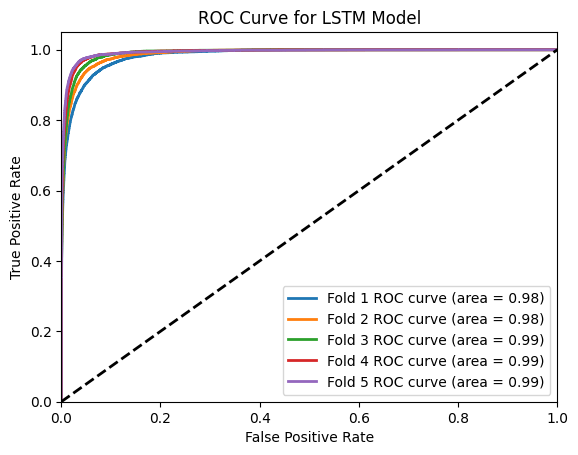

In [11]:

# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)
val_scores_lstm = []
inputs = Input(shape=(200,))
layer = Embedding(input_dim=max_words, output_dim=128, input_length=200)(inputs)
layer = Bidirectional(LSTM(32, return_sequences=True, recurrent_dropout=0.28))(layer)
layer = GlobalMaxPool1D()(layer)
layer = Dropout(0.30)(layer)
layer = Dense(32, activation='relu')(layer)
layer = Dropout(0.30)(layer)
layer = Dense(6, activation='sigmoid')(layer)
model = Model(inputs=inputs, outputs=layer)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

lstm_val_scores_f1 = []
lstm_val_scores_precision = []
lstm_val_scores_recall = []
lstm_val_scores_accuracy = []
lstm_roc_auc = []
lstm_fpr = []
lstm_tpr = []

for train_index, val_index in kf.split(X_train):
    print(train_index)
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Adjust the input data to match max_len
    X_train_fold = pad_sequences_custom(X_train_fold, 200)
    X_val_fold = pad_sequences_custom(X_val_fold, 200)

    checkpoint = ModelCheckpoint('best_model_lstm.keras', monitor='val_loss', verbose=1, save_best_only=True)
    early_stop = EarlyStopping(monitor='val_loss', patience=1)

    history_lstm = model.fit(X_train_fold, y_train_fold, batch_size=128, epochs=5, validation_split=0.2, callbacks=[checkpoint, early_stop])

    # Evaluate the model
    val_preds = model.predict(X_val_fold)
    val_preds_binary = (val_preds > 0.5).astype(int)
    
    f1 = f1_score(y_val_fold, val_preds_binary, average='macro')
    precision = precision_score(y_val_fold, val_preds_binary, average='macro')
    recall = recall_score(y_val_fold, val_preds_binary, average='macro')
    accuracy = accuracy_score(y_val_fold, val_preds_binary)

    lstm_val_scores_f1.append(f1)
    lstm_val_scores_precision.append(precision)
    lstm_val_scores_recall.append(recall)
    lstm_val_scores_accuracy.append(accuracy)
    # Calculate ROC AUC for all classes together
    auc2 = roc_auc_score(y_val_fold, val_preds, average='macro')
    fpr, tpr, _ = roc_curve(y_val_fold.ravel(), val_preds.ravel())
    lstm_roc_auc.append(auc2)
    lstm_fpr.append(fpr)
    lstm_tpr.append(tpr)


# Plot ROC curves for all classes together
plt.figure()

# Plot each fold's ROC curve
for i in range(len(lstm_fpr)):  # Each fold
    plt.plot(lstm_fpr[i], lstm_tpr[i], lw=2, label=f'Fold {i+1} ROC curve (area = {lstm_roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LSTM Model')
plt.legend(loc="lower right")
plt.show()

CNN

d:\Projects\toxic-comment-classification\venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


[     1      2      4 ... 127652 127653 127655]
Epoch 1/5
798/798 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.6304 - loss: 0.1294
Epoch 1: val_loss improved from inf to 0.05157, saving model to best_model_cnn.keras
798/798 ━━━━━━━━━━━━━━━━━━━━ 112s 139ms/step - accuracy: 0.6306 - loss: 0.1293 - val_accuracy: 0.9941 - val_loss: 0.0516
Epoch 2/5
798/798 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9185 - loss: 0.0466
Epoch 2: val_loss did not improve from 0.05157
798/798 ━━━━━━━━━━━━━━━━━━━━ 112s 140ms/step - accuracy: 0.9185 - loss: 0.0466 - val_accuracy: 0.9936 - val_loss: 0.0518
Epoch 3/5
798/798 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9140 - loss: 0.0363
Epoch 3: val_loss did not improve from 0.05157
798/798 ━━━━━━━━━━━━━━━━━━━━ 112s 140ms/step - accuracy: 0.9140 - loss: 0.0363 - val_accuracy: 0.9941 - val_loss: 0.0558
Epoch 3: early stopping
798/798 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step


d:\Projects\toxic-comment-classification\venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[     0      1      2 ... 127653 127654 127655]
Epoch 1/5
798/798 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9064 - loss: 0.0373
Epoch 1: val_loss improved from inf to 0.03162, saving model to best_model_cnn.keras
798/798 ━━━━━━━━━━━━━━━━━━━━ 112s 140ms/step - accuracy: 0.9064 - loss: 0.0373 - val_accuracy: 0.8297 - val_loss: 0.0316
Epoch 2/5
798/798 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.8320 - loss: 0.0275
Epoch 2: val_loss did not improve from 0.03162
798/798 ━━━━━━━━━━━━━━━━━━━━ 110s 138ms/step - accuracy: 0.8320 - loss: 0.0275 - val_accuracy: 0.9930 - val_loss: 0.0317
Epoch 3/5
798/798 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.7003 - loss: 0.0222
Epoch 3: val_loss did not improve from 0.03162
798/798 ━━━━━━━━━━━━━━━━━━━━ 111s 139ms/step - accuracy: 0.7003 - loss: 0.0222 - val_accuracy: 0.6919 - val_loss: 0.0364
Epoch 3: early stopping
798/798 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step


d:\Projects\toxic-comment-classification\venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[     0      2      3 ... 127651 127653 127654]
Epoch 1/5
798/798 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.6025 - loss: 0.0239
Epoch 1: val_loss improved from inf to 0.01939, saving model to best_model_cnn.keras
798/798 ━━━━━━━━━━━━━━━━━━━━ 112s 140ms/step - accuracy: 0.6025 - loss: 0.0239 - val_accuracy: 0.9205 - val_loss: 0.0194
Epoch 2/5
798/798 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.6195 - loss: 0.0173
Epoch 2: val_loss did not improve from 0.01939
798/798 ━━━━━━━━━━━━━━━━━━━━ 119s 149ms/step - accuracy: 0.6195 - loss: 0.0173 - val_accuracy: 0.7323 - val_loss: 0.0212
Epoch 3/5
798/798 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.5581 - loss: 0.0138
Epoch 3: val_loss did not improve from 0.01939
798/798 ━━━━━━━━━━━━━━━━━━━━ 115s 144ms/step - accuracy: 0.5580 - loss: 0.0138 - val_accuracy: 0.2810 - val_loss: 0.0278
Epoch 3: early stopping
798/798 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step
[     0      1      2 ... 127652 127654 127655]
Epoch 1/5
798/798 ━━━━━━━━━━━━━━━━━━

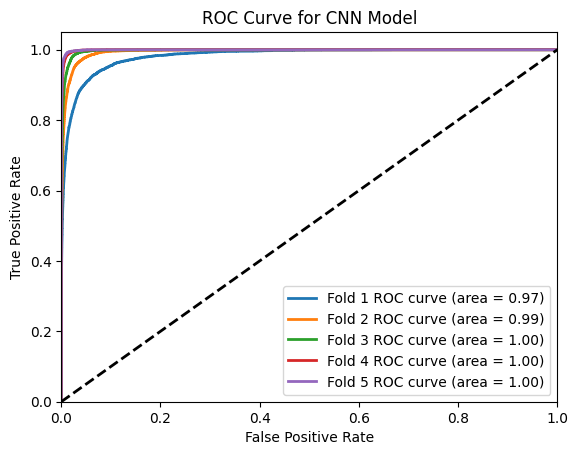

In [12]:

kf = KFold(n_splits=5, shuffle=True, random_state=42)
val_scores_cnn = []

# Define the CNN model
inputs = Input(shape=(200,))
embedding = Embedding(input_dim=max_words, output_dim=256, input_length=200)(inputs)
conv1 = Conv1D(filters=256, kernel_size=3, activation='relu')(embedding)
pool1 = MaxPooling1D(pool_size=2)(conv1)
conv2 = Conv1D(filters=256, kernel_size=3, activation='relu')(pool1)
pool2 = GlobalMaxPooling1D()(conv2)
dense1 = Dense(64, activation='relu')(pool2)
dropout = Dropout(0.20)(dense1)
outputs = Dense(6, activation='sigmoid')(dropout)
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

cnn_val_scores_f1 = []
cnn_val_scores_precision = []
cnn_val_scores_recall = []
cnn_val_scores_accuracy = []
cnn_roc_auc = []
cnn_fpr = []
cnn_tpr = []

for train_index, val_index in kf.split(X_train):
    print(train_index)
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Adjust the input data to match max_len
    X_train_fold = pad_sequences_custom(X_train_fold, 200)
    X_val_fold = pad_sequences_custom(X_val_fold, 200)
    
    # Define callbacks
    checkpoint = ModelCheckpoint('best_model_cnn.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    early_stop = EarlyStopping(monitor='val_loss', patience=2, mode='min', verbose=1)

    # Train the model
    history_cnn = model.fit(X_train_fold, y_train_fold, epochs=5, batch_size=128, validation_data=(X_val_fold, y_val_fold), callbacks=[checkpoint, early_stop])

    # Evaluate the model
    val_preds = model.predict(X_val_fold)
    val_preds_binary = (val_preds > 0.5).astype(int)

    f1 = f1_score(y_val_fold, val_preds_binary, average='macro')
    precision = precision_score(y_val_fold, val_preds_binary, average='macro')
    recall = recall_score(y_val_fold, val_preds_binary, average='macro')
    accuracy = accuracy_score(y_val_fold, val_preds_binary)

    cnn_val_scores_f1.append(f1)
    cnn_val_scores_precision.append(precision)
    cnn_val_scores_recall.append(recall)
    cnn_val_scores_accuracy.append(accuracy)
    # Calculate ROC AUC for all classes together
    auc2 = roc_auc_score(y_val_fold, val_preds, average='macro')
    fpr, tpr, _ = roc_curve(y_val_fold.ravel(), val_preds.ravel())
    cnn_roc_auc.append(auc2)
    cnn_fpr.append(fpr)
    cnn_tpr.append(tpr)

# Plot ROC curves for all classes together
plt.figure()

# Plot each fold's ROC curve
for i in range(len(cnn_fpr)):  # Each fold
    plt.plot(cnn_fpr[i], cnn_tpr[i], lw=2, label=f'Fold {i+1} ROC curve (area = {cnn_roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for CNN Model')
plt.legend(loc="lower right")
plt.show()
    

2000/2000 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step
Test F1 Score: 0.5010727549702717
Test Precision: 0.4523977287763465
Test Recall: 0.5770294890440169
Test Accuracy: 0.8510738066210259
Test ROC AUC: 0.9545722203344331


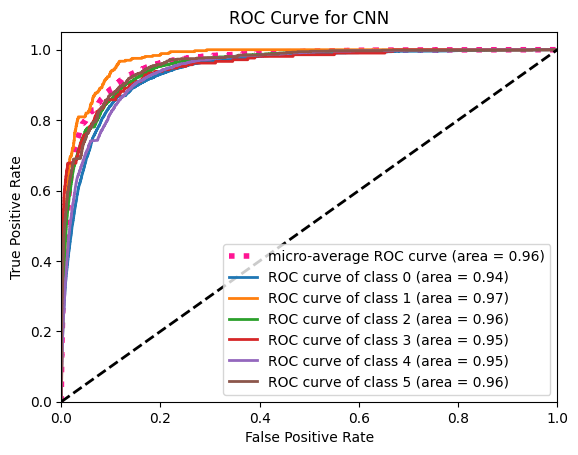

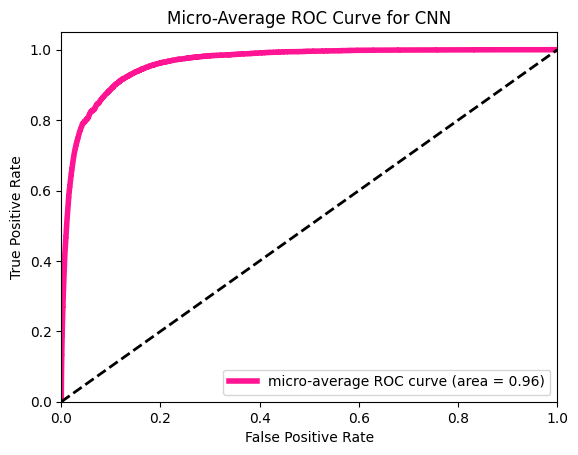

In [36]:
#CNN
# Test the model on X_test
best_model = load_model('best_model_cnn.keras')
X_test_padded = pad_sequences_custom(X_test_data_padded, 200)
test_preds = best_model.predict(X_test_padded)
test_preds_binary = (test_preds > 0.5).astype(int)

# Calculate metrics on test data
test_f1 = f1_score(y_test_binary, test_preds_binary, average='macro')
test_precision = precision_score(y_test_binary, test_preds_binary, average='macro')
test_recall = recall_score(y_test_binary, test_preds_binary, average='macro')
test_accuracy = accuracy_score(y_test_binary, test_preds_binary)
test_auc = roc_auc_score(y_test_binary, test_preds, average='macro')

print('Test F1 Score:', test_f1)
print('Test Precision:', test_precision)
print('Test Recall:', test_recall)
print('Test Accuracy:', test_accuracy)
print('Test ROC AUC:', test_auc)

# Calculate ROC curve and AUC for each label and then average
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_binary.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binary[:, i], test_preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binary.ravel(), test_preds.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve for each class
plt.figure()
plt.plot(fpr["micro"], tpr["micro"], 
         label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve of class {0} (area = {1:0.2f})'
                                      ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for CNN')
plt.legend(loc="lower right")

# Save the first plot to a PNG file
plt.savefig('roc_curve_multiclass_cnn.png')
plt.show()

# Plot micro-average ROC curve separately
plt.figure()
plt.plot(fpr["micro"], tpr["micro"], 
         label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
         color='deeppink', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-Average ROC Curve for CNN')
plt.legend(loc="lower right")

# Save the second plot to a PNG file
plt.savefig('roc_curve_micro_cnn.png')
plt.show()

2000/2000 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step


d:\Projects\toxic-comment-classification\venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test F1 Score: 0.4113362968810294
Test Precision: 0.43931758486933914
Test Recall: 0.4488166566643809
Test Accuracy: 0.8666416580699615
Test ROC AUC: 0.9644822394877709


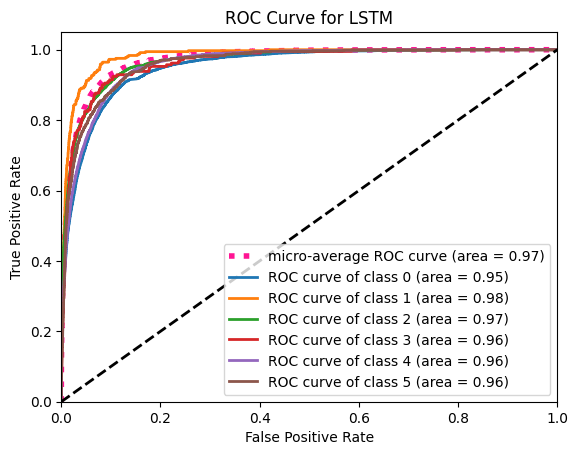

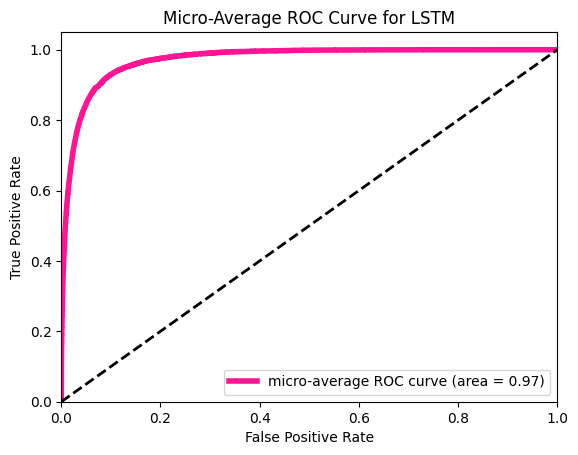

In [37]:
# Load the model and prepare the test data
best_model = load_model('best_model_lstm.keras')
X_test_padded = pad_sequences_custom(X_test_data_padded, 200)
test_preds = best_model.predict(X_test_padded)
test_preds_binary = (test_preds > 0.5).astype(int)

# Calculate metrics on test data
test_f1 = f1_score(y_test_binary, test_preds_binary, average='macro')
test_precision = precision_score(y_test_binary, test_preds_binary, average='macro')
test_recall = recall_score(y_test_binary, test_preds_binary, average='macro')
test_accuracy = accuracy_score(y_test_binary, test_preds_binary)
test_auc = roc_auc_score(y_test_binary, test_preds, average='macro')

print('Test F1 Score:', test_f1)
print('Test Precision:', test_precision)
print('Test Recall:', test_recall)
print('Test Accuracy:', test_accuracy)
print('Test ROC AUC:', test_auc)

# Calculate ROC curve and AUC for each label and then average
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_binary.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binary[:, i], test_preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binary.ravel(), test_preds.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve for each class
plt.figure()
plt.plot(fpr["micro"], tpr["micro"], 
         label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve of class {0} (area = {1:0.2f})'
                                      ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LSTM')
plt.legend(loc="lower right")

# Save the first plot to a PNG file
plt.savefig('roc_curve_multiclass_lstm.png')
plt.show()

# Plot micro-average ROC curve separately
plt.figure()
plt.plot(fpr["micro"], tpr["micro"], 
         label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
         color='deeppink', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-Average ROC Curve for LSTM')
plt.legend(loc="lower right")

# Save the second plot to a PNG file
plt.savefig('roc_curve_micro_lstm.png')
plt.show()

Best parameters from RandomizedSearchCV: {'estimator__C': 9.51714306409916, 'estimator__penalty': 'l2'}
              precision    recall  f1-score   support

           0       0.86      0.67      0.76     12238
           1       0.53      0.30      0.38      1274
           2       0.88      0.69      0.77      6734
           3       0.63      0.25      0.35       404
           4       0.77      0.56      0.65      6263
           5       0.59      0.28      0.38      1111

   micro avg       0.83      0.61      0.70     28024
   macro avg       0.71      0.46      0.55     28024
weighted avg       0.82      0.61      0.70     28024
 samples avg       0.06      0.05      0.05     28024

Test F1 Score: 0.5341275059247795
Test Precision: 0.5653286218203171
Test Recall: 0.5208260538004311
Test Accuracy: 0.8827565725718216
Test ROC AUC: 0.7521798499729816


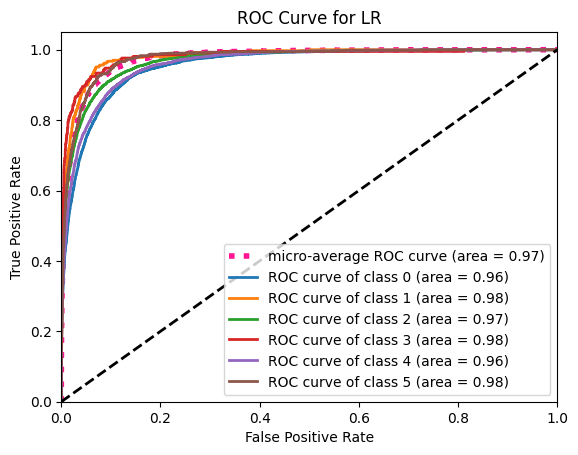

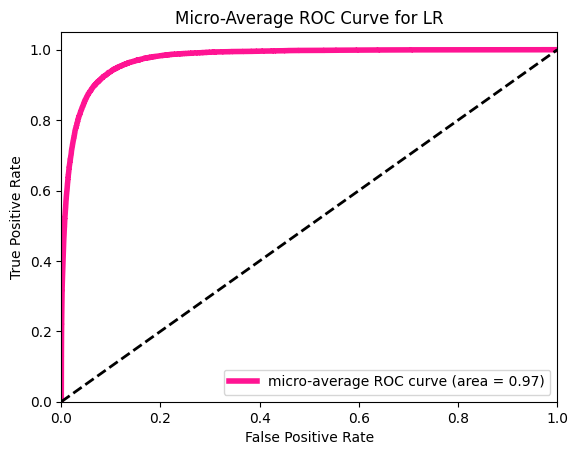

In [46]:
param_distributions = {
    'estimator__C': uniform(loc=0.01, scale=10),
    'estimator__penalty': ['l2']
}

estimator_LR = MultiOutputClassifier(LogisticRegression(solver='lbfgs', max_iter=1000, verbose=True))

random_search_LR = RandomizedSearchCV(
    estimator=estimator_LR,
    param_distributions=param_distributions,
    n_iter=4,
    cv=3,
    random_state=42,
    scoring='f1_weighted'
)

def remove_prefix(d, prefix='estimator__'):
    return {k[len(prefix):]: v for k, v in d.items() if k.startswith(prefix)}

def LR_Training_CV(y_label, X_padded, tokenizer, k=5):
    # Perform parameter search on the entire dataset
    X_text = [' '.join(tokenizer.sequences_to_texts([comment])[0].split()) for comment in X_padded]
    
    tfidf_vec = TfidfVectorizer(max_df=0.7)
    X_vec = tfidf_vec.fit_transform(X_text)
    
    random_search_LR.fit(X_vec, y_label)
    best_params = random_search_LR.best_params_
    print('Best parameters from RandomizedSearchCV:', best_params)
    
    # Clean the best parameters
    cleaned_params = remove_prefix(best_params)
    
    # Use the best parameters for cross-validation
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
    all_predictions = []
    all_y_tests = []
    modelLR = MultiOutputClassifier(LogisticRegression(solver='lbfgs', max_iter=1000, verbose=True, **cleaned_params))

    for train_index, test_index in kf.split(X_padded):
        X_train_LR, X_test_LR = X_padded[train_index], X_padded[test_index]
        y_train_LR, y_test_LR = y_label[train_index], y_label[test_index]
        
        X_train_LR = [' '.join(tokenizer.sequences_to_texts([comment])[0].split()) for comment in X_train_LR]
        X_test_LR = [' '.join(tokenizer.sequences_to_texts([comment])[0].split()) for comment in X_test_LR]
        
        X_train_LR_vec = tfidf_vec.fit_transform(X_train_LR)
        X_test_LR_vec = tfidf_vec.transform(X_test_LR)
        
        modelLR.fit(X_train_LR_vec, y_train_LR)
        
        predictions = modelLR.predict(X_test_LR_vec)
        
        all_predictions.extend(predictions)
        all_y_tests.extend(y_test_LR)
    
    # Print classification report
    print(classification_report(all_y_tests, all_predictions, zero_division=0))
    accuracy = accuracy_score(all_y_tests, all_predictions)
    report = classification_report(all_y_tests, all_predictions, output_dict=True, zero_division=0)

    return modelLR, tfidf_vec

# Trenuj model LR
modelLR, tfidf_vec_LR = LR_Training_CV(y_train, X_train, tokenizer)

# Prepare test data
X_test_text = [' '.join(tokenizer.sequences_to_texts([comment])[0].split()) for comment in X_test_data_padded]
X_test_vec = tfidf_vec_LR.transform(X_test_text)

# Predict on test data
test_preds = modelLR.predict_proba(X_test_vec)

# Convert list of arrays to a single array
test_preds_array = np.array([pred[:, 1] for pred in test_preds]).T
test_preds_binary = (test_preds_array > 0.5).astype(int)

test_f1 = f1_score(y_test_binary, test_preds_binary, average='macro')
test_precision = precision_score(y_test_binary, test_preds_binary, average='macro')
test_recall = recall_score(y_test_binary, test_preds_binary, average='macro')
test_accuracy = accuracy_score(y_test_binary, test_preds_binary)
test_auc = roc_auc_score(y_test_binary, test_preds_binary, average='macro')

print('Test F1 Score:', test_f1)
print('Test Precision:', test_precision)
print('Test Recall:', test_recall)
print('Test Accuracy:', test_accuracy)
print('Test ROC AUC:', test_auc)

# Calculate ROC curve and AUC for each label and then average
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_binary.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binary[:, i], test_preds_array[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binary.ravel(), test_preds_array.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve for each class
plt.figure()
plt.plot(fpr["micro"], tpr["micro"], 
         label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve of class {0} (area = {1:0.2f})'
                                      ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LR')
plt.legend(loc="lower right")
plt.savefig('roc_curve_multiclass_LR.png')
plt.show()

# Plot micro-average ROC curve separately
plt.figure()
plt.plot(fpr["micro"], tpr["micro"], 
         label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
         color='deeppink', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-Average ROC Curve for LR')
plt.legend(loc="lower right")
plt.savefig('roc_curve_micro_LR.png')
plt.show()


Best parameters from RandomizedSearchCV: {'estimator__alpha': 0.3745401188473625, 'estimator__fit_prior': True}
              precision    recall  f1-score   support

           0       0.91      0.51      0.66     12238
           1       0.64      0.09      0.16      1274
           2       0.89      0.51      0.65      6734
           3       0.50      0.00      0.00       404
           4       0.82      0.43      0.56      6263
           5       0.75      0.04      0.08      1111

   micro avg       0.88      0.45      0.59     28024
   macro avg       0.75      0.26      0.35     28024
weighted avg       0.86      0.45      0.58     28024
 samples avg       0.05      0.04      0.04     28024

Accuracy: 0.9117706962461616
Test F1 Score: 0.33684830150625594
Test Precision: 0.5764778719924257
Test Recall: 0.2691331625782896
Test Accuracy: 0.899262246397199
Test ROC AUC: 0.6309132473390863


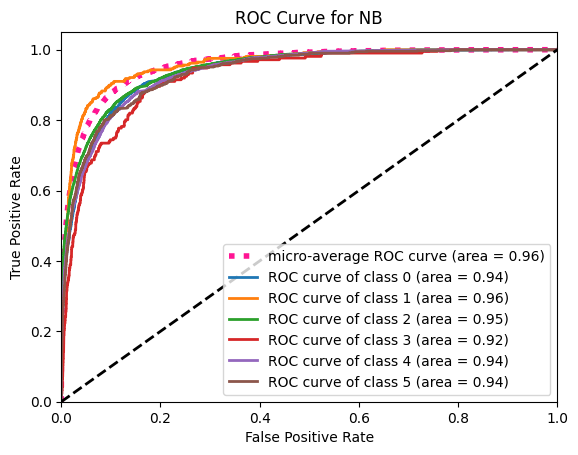

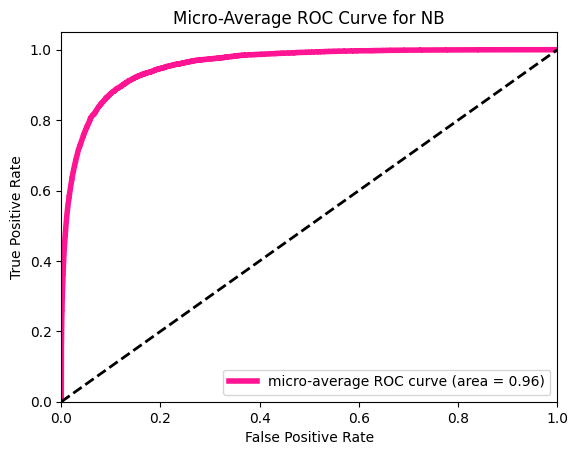

In [47]:
param_distributions = {
    'estimator__alpha': uniform(loc=0, scale=1),
    'estimator__fit_prior': [True, False]
}

estimator_NB = MultiOutputClassifier(MultinomialNB())

random_search_NB = RandomizedSearchCV(
    estimator=estimator_NB,
    param_distributions=param_distributions,
    n_iter=4,
    cv=3,
    random_state=42,
    scoring='f1_weighted'
)

def NB_Training_CV(y_label, X_padded, tokenizer, k=5):
    # Perform parameter search on the entire dataset
    X_text = [' '.join(tokenizer.sequences_to_texts([comment])[0].split()) for comment in X_padded]

    tfidf_vec = TfidfVectorizer(max_df=0.7)
    X_vec = tfidf_vec.fit_transform(X_text)

    random_search_NB.fit(X_vec, y_label)
    best_params = random_search_NB.best_params_
    print('Best parameters from RandomizedSearchCV:', best_params)
    
    cleaned_params = remove_prefix(best_params)

    # Use the best parameters for cross-validation
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    all_predictions = []
    all_y_tests = []
    modelNB = MultiOutputClassifier(MultinomialNB(**cleaned_params))
    for train_index, test_index in kf.split(X_padded):
        X_train_NB, X_test_NB = X_padded[train_index], X_padded[test_index]
        y_train_NB, y_test_NB = y_label[train_index], y_label[test_index]

        X_train_NB = [' '.join(tokenizer.sequences_to_texts([comment])[0].split()) for comment in X_train_NB]
        X_test_NB = [' '.join(tokenizer.sequences_to_texts([comment])[0].split()) for comment in X_test_NB]

        X_train_NB_vec = tfidf_vec.fit_transform(X_train_NB)
        X_test_NB_vec = tfidf_vec.transform(X_test_NB)

        modelNB.fit(X_train_NB_vec, y_train_NB)

        predictions = modelNB.predict(X_test_NB_vec)

        all_predictions.extend(predictions)
        all_y_tests.extend(y_test_NB)

    # Print classification report
    print(classification_report(all_y_tests, all_predictions, zero_division=0))
    
    # Calculate and return metrics
    report = classification_report(all_y_tests, all_predictions, output_dict=True, zero_division=0)
    accuracy = accuracy_score(all_y_tests, all_predictions)
    print('Accuracy:', accuracy)
    return modelNB, tfidf_vec

# Trenuj model NB
modelNB, tfidf_vec_NB = NB_Training_CV(y_train, X_train, tokenizer)

# Prepare test data
X_test_text = [' '.join(tokenizer.sequences_to_texts([comment])[0].split()) for comment in X_test_data_padded]
X_test_vec = tfidf_vec_NB.transform(X_test_text)

# Predict on test data
test_preds = modelNB.predict_proba(X_test_vec)

# Convert list of arrays to a single array
test_preds_array = np.array([pred[:, 1] for pred in test_preds]).T
test_preds_binary = (test_preds_array > 0.5).astype(int)

test_f1 = f1_score(y_test_binary, test_preds_binary, average='macro')
test_precision = precision_score(y_test_binary, test_preds_binary, average='macro')
test_recall = recall_score(y_test_binary, test_preds_binary, average='macro')
test_accuracy = accuracy_score(y_test_binary, test_preds_binary)
test_auc = roc_auc_score(y_test_binary, test_preds_binary, average='macro')

print('Test F1 Score:', test_f1)
print('Test Precision:', test_precision)
print('Test Recall:', test_recall)
print('Test Accuracy:', test_accuracy)
print('Test ROC AUC:', test_auc)

# Calculate ROC curve and AUC for each label and then average
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_binary.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binary[:, i], test_preds_array[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binary.ravel(), test_preds_array.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve for each class
plt.figure()
plt.plot(fpr["micro"], tpr["micro"], 
         label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve of class {0} (area = {1:0.2f})'
                                      ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for NB')
plt.legend(loc="lower right")
plt.savefig('roc_curve_multiclass_NB.png')
plt.show()

# Plot micro-average ROC curve separately
plt.figure()
plt.plot(fpr["micro"], tpr["micro"], 
         label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
         color='deeppink', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-Average ROC Curve for NB')
plt.legend(loc="lower right")
plt.savefig('roc_curve_micro_NB.png')
plt.show()



In [40]:
results_metrics = {
    'Regresja_Liniowa': {
        'accuracy': [],
        'precision': [ 0.86, 0.53, 0.88, 0.63, 0.77],
        'recall': [0.67, 0.30, 0.69, 0.25, 0.56],
        'f1_score': [0.76, 0.38, 0.77, 0.35, 0.65]
    },
    'Naive_Bayes': {
        'accuracy': [],
        'precision': [0.91, 0.64, 0.89, 0.82, 0.75],
        'recall': [0.51, 0.09, 0.51, 0.43, 0.04],
        'f1_score': [0.66, 0.16, 0.65, 0.56, 0.08]
    },
    'CNN': {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1_score': []
    },
    'LSTM': {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1_score': []
    }
}

results_metrics['LSTM']['accuracy']=lstm_val_scores_accuracy
results_metrics['LSTM']['precision']=lstm_val_scores_precision
results_metrics['LSTM']['recall']=lstm_val_scores_recall
results_metrics['LSTM']['f1_score']=lstm_val_scores_f1

results_metrics['CNN']['accuracy']=cnn_val_scores_accuracy
results_metrics['CNN']['precision']=cnn_val_scores_precision
results_metrics['CNN']['recall']=cnn_val_scores_recall
results_metrics['CNN']['f1_score']=cnn_val_scores_f1

print(results_metrics)
# Calculate standard deviation for each metric in each model
# std_devs = {model: {metric: np.std(values) for metric, values in metrics.items() if values} for model, metrics in results_metrics.items()}
# std_devs

{'Regresja_Liniowa': {'accuracy': [], 'precision': [0.86, 0.53, 0.88, 0.63, 0.77], 'recall': [0.67, 0.3, 0.69, 0.25, 0.56], 'f1_score': [0.76, 0.38, 0.77, 0.35, 0.65]}, 'Naive_Bayes': {'accuracy': [], 'precision': [0.91, 0.64, 0.89, 0.82, 0.75], 'recall': [0.51, 0.09, 0.51, 0.43, 0.04], 'f1_score': [0.66, 0.16, 0.65, 0.56, 0.08]}, 'CNN': {'accuracy': [0.9106219645934513, 0.9381144491010928, 0.9533899964748737, 0.9726998550781403, 0.9774391915710313], 'precision': [0.5657877320443933, 0.6265452397666254, 0.8567547701019248, 0.8584369759452292, 0.8752341362683195], 'recall': [0.40767383766367127, 0.570036215022436, 0.6283681034998138, 0.7846058066257885, 0.8668470335574727], 'f1_score': [0.43469379789660617, 0.5948709701191954, 0.6956067734358001, 0.8165099755905892, 0.869214816588496]}, 'LSTM': {'accuracy': [0.9168886103712988, 0.9240531119031765, 0.9261290196232032, 0.9346284908542556, 0.939446163487525], 'precision': [0.41998784084756235, 0.5001099631639372, 0.5441230569864873, 0.6883

In [41]:
def perform_t_tests_to_df(results_metrics, metric, alpha=0.05):
    models = list(results_metrics.keys())
    n_models = len(models)
    n_comparisons = (n_models * (n_models - 1)) / 2
    bonferroni_alpha = alpha / n_comparisons
    results = []

    for i in range(n_models):
        for j in range(i + 1, n_models):
            model_1 = models[i]
            model_2 = models[j]
            scores_1 = results_metrics[model_1][metric]
            scores_2 = results_metrics[model_2][metric]
            differences = [a - b for a, b in zip(scores_1, scores_2)]
            
            # Perform the Shapiro-Wilk test for normality
            shapiro_stat, shapiro_p_value = shapiro(differences)
            
            if shapiro_p_value > 0.05:
                # If the p-value is greater than 0.05, we assume normality and use t-test
                t_stat, p_value = ttest_rel(scores_1, scores_2)
                test_used = 't-test'
            else:
                # If the p-value is less than or equal to 0.05, we use the Wilcoxon signed-rank test
                t_stat, p_value = wilcoxon(scores_1, scores_2)
                test_used = 'wilcoxon'
                
            results.append({
                'Metric': metric,
                'Model 1': model_1,
                'Model 2': model_2,
                'Test': test_used,
                't-stat': t_stat,
                'p-value': p_value,
                'Corrected p-value': p_value * n_comparisons,
                'Significant': p_value < bonferroni_alpha,
                'Normality p-value': shapiro_p_value
            })

    return pd.DataFrame(results)

# Przeprowadzenie t-testów dla precision, recall i f1-score i zapis wyników do DataFrame
df_precision = perform_t_tests_to_df(results_metrics, 'precision')
df_recall = perform_t_tests_to_df(results_metrics, 'recall')
df_f1_score = perform_t_tests_to_df(results_metrics, 'f1_score')

# Połączenie wyników w jeden DataFrame
df_results = pd.concat([df_precision, df_recall, df_f1_score], ignore_index=True)

# Zapis wyników do pliku LaTeX
latex_table = df_results.to_latex(index=False, float_format="%.4f")

print(latex_table)

# Zapis tabeli LaTeX do pliku
with open('t_test_results.tex', 'w') as f:
    f.write(latex_table)

\begin{tabular}{llllrrrrr}
\toprule
Metric & Model 1 & Model 2 & Test & t-stat & p-value & Corrected p-value & Significant & Normality p-value \\
\midrule
precision & Regresja_Liniowa & Naive_Bayes & t-test & -1.8148 & 0.1437 & 0.8625 & False & 0.7689 \\
precision & Regresja_Liniowa & CNN & t-test & -0.2544 & 0.8117 & 4.8703 & False & 0.4745 \\
precision & Regresja_Liniowa & LSTM & t-test & 1.9232 & 0.1268 & 0.7609 & False & 0.7491 \\
precision & Naive_Bayes & CNN & t-test & 0.5712 & 0.5984 & 3.5904 & False & 0.2163 \\
precision & Naive_Bayes & LSTM & t-test & 3.3495 & 0.0286 & 0.1715 & False & 0.0773 \\
precision & CNN & LSTM & t-test & 5.7468 & 0.0045 & 0.0273 & True & 0.4508 \\
recall & Regresja_Liniowa & Naive_Bayes & t-test & 1.6034 & 0.1841 & 1.1047 & False & 0.5583 \\
recall & Regresja_Liniowa & CNN & t-test & -1.1117 & 0.3286 & 1.9714 & False & 0.7603 \\
recall & Regresja_Liniowa & LSTM & t-test & 0.7559 & 0.4918 & 2.9507 & False & 0.5334 \\
recall & Naive_Bayes & CNN & t-test 